# <center>Тестове завдання в OBRIO</center>

### Імпорт бібліотек

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

import requests
import json

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn import preprocessing

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")

### Вивантаження даних

In [2]:
df = pd.read_csv('test_payment_data.csv', parse_dates=['event_time'], index_col='#')

## Опис полів транзакції

- **order_id**: Унікальний ідентифікатор платіжного ордеру.
- **event_time**: Дата та час транзакції.
- **user_id**: Унікальний ідентифікатор користувача.
- **price**: Ціна у валюті.
- **payment_number**: Тип транзакції (перша чи повторна).
- **transaction_status**: Статус транзакції (успіх або невдача).
- **card_brand**: Бренд картки.
- **card_type**: Тип картки.
- **bank_name**: Назва банку емітента.
- **error_type**: Тип помилки платежу.
- **currency**: Валюта платежу.
- **card_country**: Код країни.

In [3]:
df.head(3)

,order_id,event_time,user_id,price,payment_number,transaction_status,card_brand,card_type,bank_name,error_type,currency,card_country
#,,,,,,,,,,,,
1,c500aa10-30f8-4927-96c5-4e97b6afac83,2022-07-08 18:32:39,c1ed5188-caac-4d56-bad8-bc8ee0b09960,21.0,reccurent,fail,VISA,PREPAID,ADVANCED BANK OF ASIA LIMITED,3.08,USD,KHM
2,624d6f30-c1bc-4778-a23e-6a227bac73ac,2022-06-09 22:18:36,c9ff65b8-75e6-467f-8715-21edb5fd06af,36.0,reccurent,fail,VISA,PREPAID,UNITED BANK FOR AFRICA GHANA LIMITED,3.02,USD,GHA
3,4d75ca57-8883-49a9-b150-1ab7a47d12f8,2022-06-09 11:18:32,1005d4fb-1b7d-4715-835f-4d2a9bfe7cbb,36.0,initial,success,VISA,CREDIT,ICICI BANK LTD,NaN,USD,IND


In [4]:
print(f'Розмір датафрейму: {df.shape[0]} рядків та {df.shape[1]} стовпців.')

Розмір датафрейму: 566413 рядків та 12 стовпців.


In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
event_time,566413,2022-08-04 23:24:55.646206720,2022-01-01 00:00:36,2022-06-10 10:13:47,2022-08-10 23:29:47,2022-10-24 06:31:49,2022-12-31 23:59:16,NaN
price,566413.0,24.641491,4.0,9.0,24.0,36.0,107.0,15.621955
error_type,313048.0,3.101521,0.01,3.02,3.02,3.1,7.07,0.796814


In [6]:
df.dtypes

order_id                      object
event_time            datetime64[ns]
user_id                       object
price                        float64
payment_number                object
transaction_status            object
card_brand                    object
card_type                     object
bank_name                     object
error_type                   float64
currency                      object
card_country                  object
dtype: object

In [7]:
df.isnull().sum()

order_id                   0
event_time                 0
user_id                    0
price                      0
payment_number             0
transaction_status         0
card_brand                 0
card_type                770
bank_name               2009
error_type            253365
currency                   0
card_country             527
dtype: int64

#### Маємо пропуски в колонках card_type, bank_name, card_country, а пропуски в error_type означають, що транзакція була успішною.

In [8]:
df.dropna(subset=['card_type', 'bank_name', 'card_country'], inplace=True)

In [9]:
print('Кількість дублікатів:', df.duplicated().sum())

Кількість дублікатів: 1095


In [10]:
df.drop_duplicates(inplace=True)

#### Використаємо дані Національного банку України для конвертації ціни в канадський долар.

In [11]:
dct = {
    'date': [],
    'usd': [],
    'eur': [],
    'cad': []
}

start = df.event_time.min().strftime('%Y%m%d')
end = df.event_time.max().strftime('%Y%m%d')

url = f'https://bank.gov.ua/NBU_Exchange/exchange_site?start={start}&end=%20{end}&valcode=usd&sort=exchangedate&order=desc&json'
req = requests.get(url).json()

for item in req:
    dct['date'].append(item['exchangedate'])
    dct['usd'].append(item['rate'])

url = f'https://bank.gov.ua/NBU_Exchange/exchange_site?start={start}&end=%20{end}&valcode=eur&sort=exchangedate&order=desc&json'
req = requests.get(url).json()

for item in req:
    dct['eur'].append(item['rate'])

url = f'https://bank.gov.ua/NBU_Exchange/exchange_site?start={start}&end=%20{end}&valcode=cad&sort=exchangedate&order=desc&json'
req = requests.get(url).json()

for item in req:
    dct['cad'].append(item['rate'])

In [12]:
convertator_df = pd.DataFrame(dct)
convertator_df['usd_coef'] = convertator_df.usd / convertator_df.cad
convertator_df['eur_coef'] = convertator_df.eur / convertator_df.cad

convertator_df.date = pd.to_datetime(convertator_df.date)

In [13]:
convertator_df['date'] = pd.to_datetime(convertator_df['date'])
df['event_time_convertator'] = pd.to_datetime(df['event_time']).dt.date

df['event_time_convertator'] = pd.to_datetime(df['event_time_convertator'])

merged_df = df.merge(convertator_df, left_on='event_time_convertator', right_on='date', how='left')


def convert_currency(row):
    if row['currency'] == 'USD':
        return round(row['price'] * row['usd_coef'], 2)
    elif round(row['currency'] == 'EUR', 2):
        return row['price'] * row['eur_coef']
    else:
        return row['price']  


merged_df['price_in_cad'] = merged_df.apply(convert_currency, axis=1)

In [14]:
merged_df.columns

Index(['order_id', 'event_time', 'user_id', 'price', 'payment_number',
       'transaction_status', 'card_brand', 'card_type', 'bank_name',
       'error_type', 'currency', 'card_country', 'event_time_convertator',
       'date', 'usd', 'eur', 'cad', 'usd_coef', 'eur_coef', 'price_in_cad'],
      dtype='object')

In [15]:
df = merged_df.drop(['event_time_convertator', 'date', 'usd', 'eur', 'cad', 'usd_coef', 'eur_coef'], axis=1)

#### Додамо колонки з номером та днем тижня.

In [16]:
df['day_of_week'] = df['event_time'].dt.day_name()

In [17]:
df['event_week'] = df['event_time'].dt.isocalendar().week

In [18]:
df.head()

,order_id,event_time,user_id,price,payment_number,transaction_status,card_brand,card_type,bank_name,error_type,currency,card_country,price_in_cad,day_of_week,event_week
0,c500aa10-30f8-4927-96c5-4e97b6afac83,2022-07-08 18:32:39,c1ed5188-caac-4d56-bad8-bc8ee0b09960,21.0,reccurent,fail,VISA,PREPAID,ADVANCED BANK OF ASIA LIMITED,3.08,USD,KHM,27.26,Friday,27
1,624d6f30-c1bc-4778-a23e-6a227bac73ac,2022-06-09 22:18:36,c9ff65b8-75e6-467f-8715-21edb5fd06af,36.0,reccurent,fail,VISA,PREPAID,UNITED BANK FOR AFRICA GHANA LIMITED,3.02,USD,GHA,45.14,Thursday,23
2,4d75ca57-8883-49a9-b150-1ab7a47d12f8,2022-06-09 11:18:32,1005d4fb-1b7d-4715-835f-4d2a9bfe7cbb,36.0,initial,success,VISA,CREDIT,ICICI BANK LTD,NaN,USD,IND,45.14,Thursday,23
3,3fd11eed-4236-46aa-8f21-3c1e1a17a1bc,2022-06-29 13:50:47,866c4b2b-0285-43aa-98bd-d60bc3a78d7c,36.0,reccurent,fail,VISA,DEBIT,THE TORONTO-DOMINION BANK,3.02,USD,CAN,46.24,Wednesday,26
4,3b19657f-1a34-4233-b25c-5d3b7fb32782,2022-06-17 15:16:47,bd2e4137-5526-4d9b-9dde-7482087fc321,9.0,reccurent,success,MASTERCARD,CREDIT,"CAPITAL ONE BANK (USA), NATIONAL ASSOCIATION",NaN,USD,USA,11.65,Friday,24


### 1. Проаналізуй потижневу прохідність платежів у трьох локаціях: США, Європа та інші країни.

In [19]:
df.currency.unique()

array(['USD', 'EUR'], dtype=object)

In [20]:
df['currency'].value_counts()

currency
USD    514785
EUR     47930
Name: count, dtype: int64

In [21]:
df.card_country.unique()

array(['KHM', 'GHA', 'IND', 'CAN', 'USA', 'MEX', 'MYS', 'TUR', 'ROU',
       'COL', 'IDN', 'AUS', 'HKG', 'GRC', 'PAK', 'FRA', 'CHL', 'SGP',
       'GBR', 'ESP', 'ZWE', 'PRT', 'NGA', 'FIN', 'EST', 'MDA', 'PAN',
       'MNG', 'CHE', 'BRA', 'LBR', 'ZAF', 'JAM', 'ECU', 'LVA', 'POL',
       'NZL', 'EGY', 'SVK', 'TTO', 'SRB', 'ITA', 'IRL', 'NLD', 'VEN',
       'GTM', 'NAM', 'GEO', 'TZA', 'ARG', 'UKR', 'BHR', 'NPL', 'SWE',
       'CZE', 'BHS', 'PHL', 'PRI', 'LTU', 'ALB', 'KEN', 'BOL', 'JOR',
       'LCA', 'BIH', 'BMU', 'PER', 'MAC', 'MDG', 'BRN', 'URY', 'ARE',
       'HRV', 'LKA', 'CRI', 'VNM', 'THA', 'AUT', 'ISR', 'ISL', 'QAT',
       'BGR', 'BRB', 'RWA', 'AZE', 'HUN', 'DZA', 'HND', 'BEL', 'DNK',
       'LUX', 'PRY', 'KOR', 'CYP', 'MUS', 'ABW', 'CMR', 'SLV', 'KAZ',
       'SSD', 'MNE', 'NIC', 'MLT', 'SEN', 'SAU', 'NOR', 'KWT', 'PSE',
       'GAB', 'JPN', 'DOM', 'MMR', 'DEU', 'SYC', 'RUS', 'OMN', 'SVN',
       'CYM', 'ZMB', 'UGA', 'ARM', 'TWN', 'CUW', 'MAR', 'BLR', 'MOZ',
       'IRQ', 'KNA',

#### Класифікуємо країни.

In [22]:
europe_country_codes = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD',
    'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR'
]

def classify_country(country_code):
    if pd.isnull(country_code):
        return None  
    if country_code == 'USA':
        return 'USA'
    elif country_code in europe_country_codes:
        return 'Europe'
    else:
        return 'Other'

df['region'] = df['card_country'].apply(classify_country)

#### Агрегуємо дані для отримання датафрейма з кількістю транзакцій по регіонам.

In [23]:
df_week_transaction = df[df.region != 'Unknown'].groupby(['region', 'transaction_status', 'event_week']).agg({'transaction_status': 'count'}) \
    .rename(columns={'transaction_status': 'amount_transaction'}).reset_index()

In [24]:
df_week_transaction.head()

,region,transaction_status,event_week,amount_transaction
0,Europe,fail,1,319
1,Europe,fail,2,234
2,Europe,fail,3,243
3,Europe,fail,4,288
4,Europe,fail,5,234


#### Побудуємо графіки потижневої прохідності платежів для Європи, США та інших країн

In [25]:
df_week_europe = df_week_transaction[df_week_transaction.region == 'Europe']
df_week_other = df_week_transaction[df_week_transaction.region == 'Other']
df_week_usa = df_week_transaction[df_week_transaction.region == 'USA']

In [26]:
def graph_transaction_status_country(df_graph, name):

    fail_df = df_graph[df_graph.transaction_status == 'fail']
    success_df = df_graph[df_graph.transaction_status == 'success']
    
    plt.figure(figsize=(20, 6))
    
    plt.bar(success_df['event_week'] - 0.2, success_df['amount_transaction'], color='green', width=0.4, label='Success')
        
    plt.bar(fail_df['event_week'] + 0.2, fail_df['amount_transaction'], color='red', width=0.4, label='Fail')
    
    plt.title(f'Кількість транзакцій в {name}', fontsize=18)
    plt.xlabel('Номер тижня', fontsize=14)
    plt.ylabel('Кількість', fontsize=14)
        
    
    plt.xticks(range(min(df_graph.event_week), max(df_graph.event_week) + 1, 1))
    plt.legend()
    plt.show()

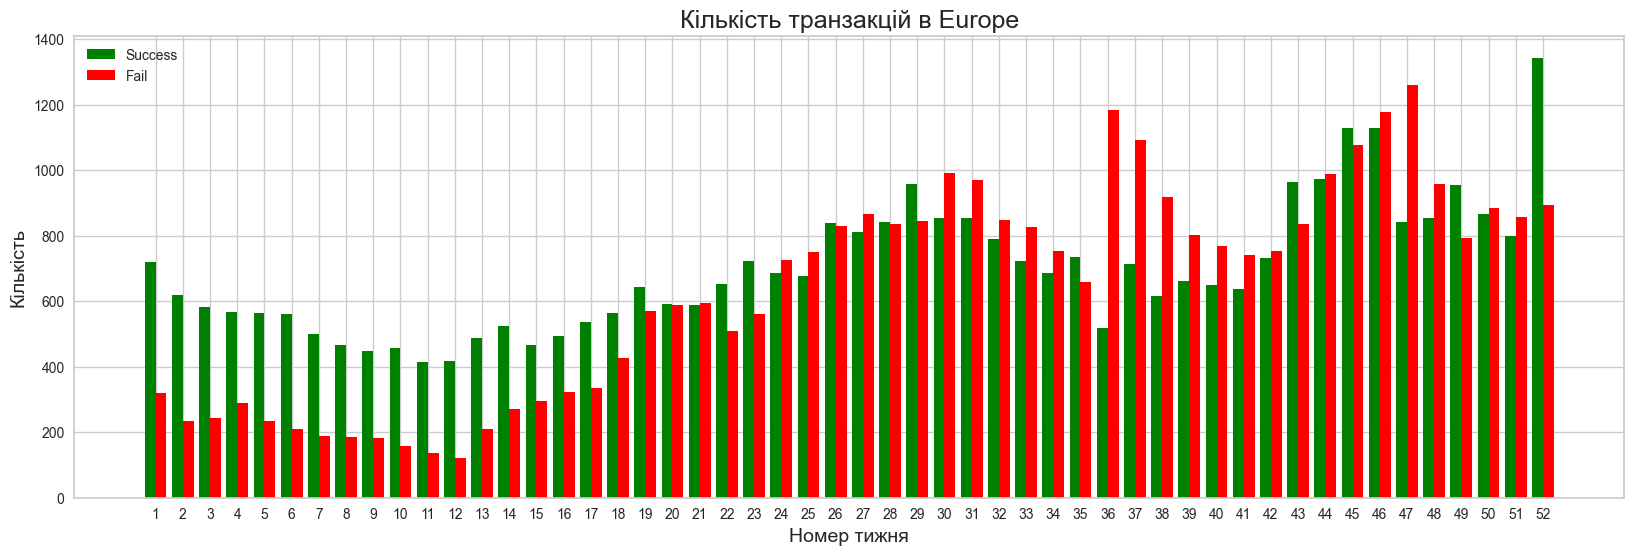

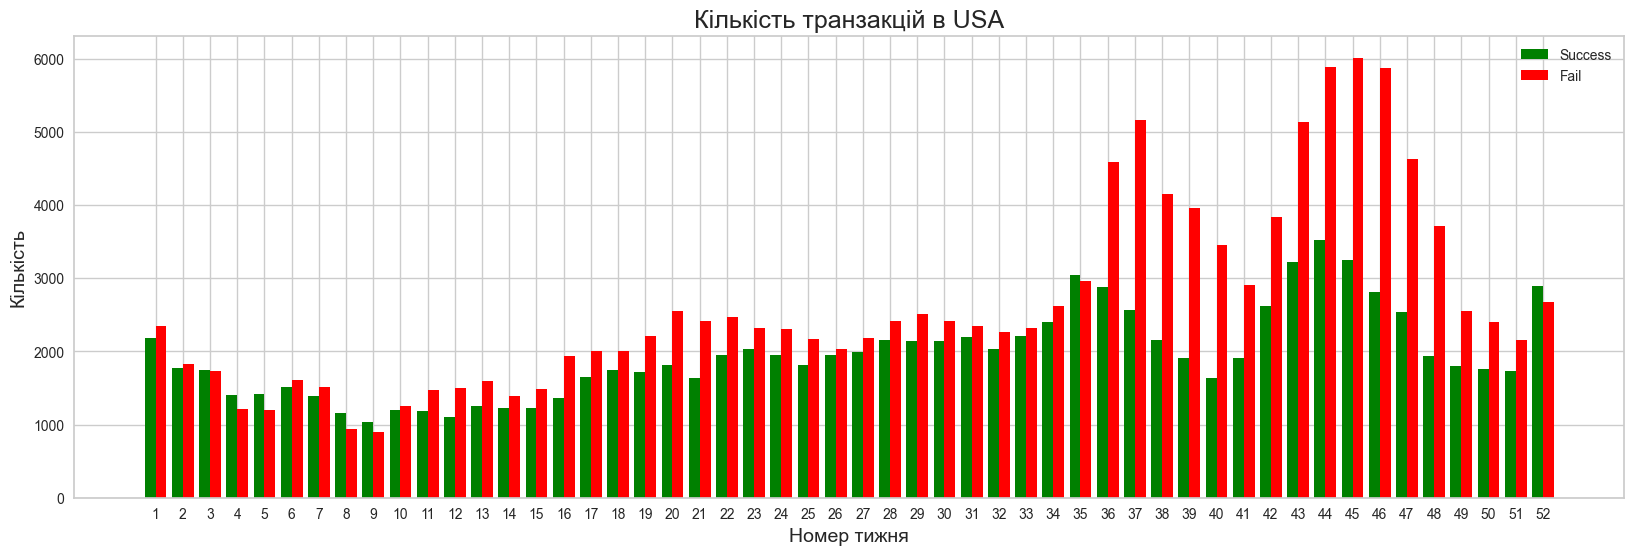

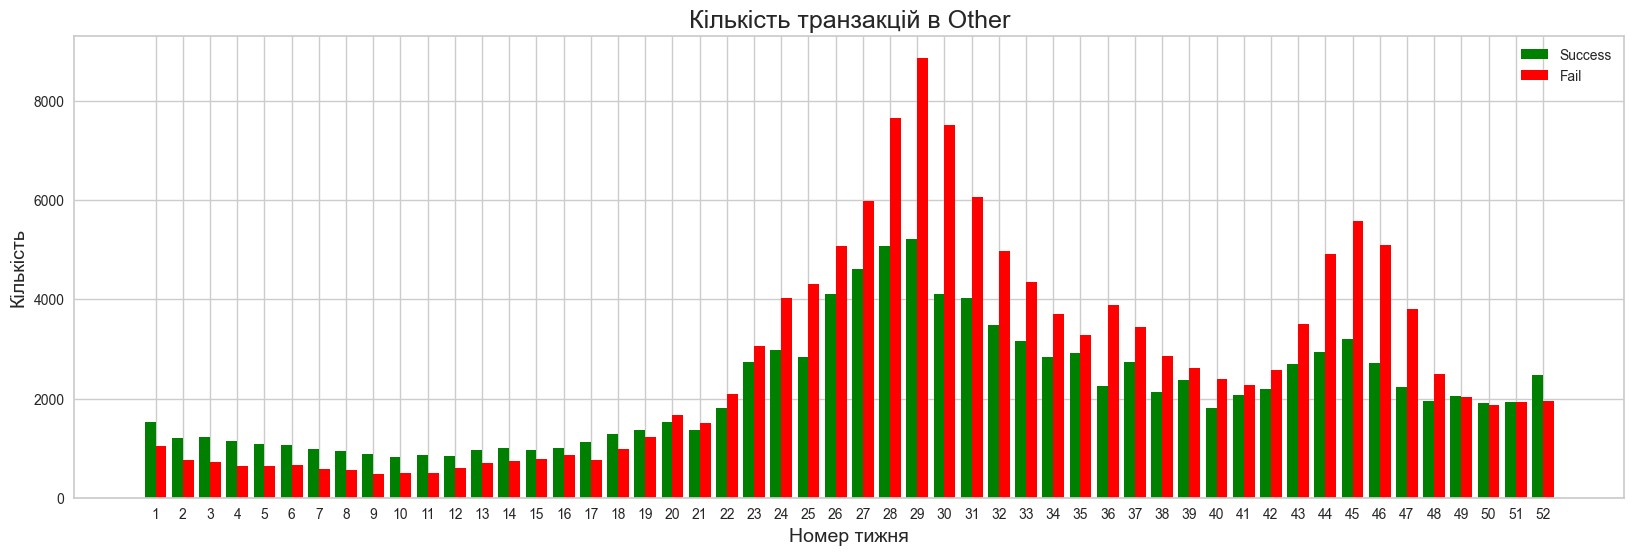

In [27]:
graph_transaction_status_country(df_week_europe, 'Europe')
graph_transaction_status_country(df_week_usa, 'USA')
graph_transaction_status_country(df_week_other, 'Other')

#### Бачимо в правій частині збільшення частини відхилених транзакцій, проглянемо які з них найчастіше зустрічаються в різних частинах графіка.

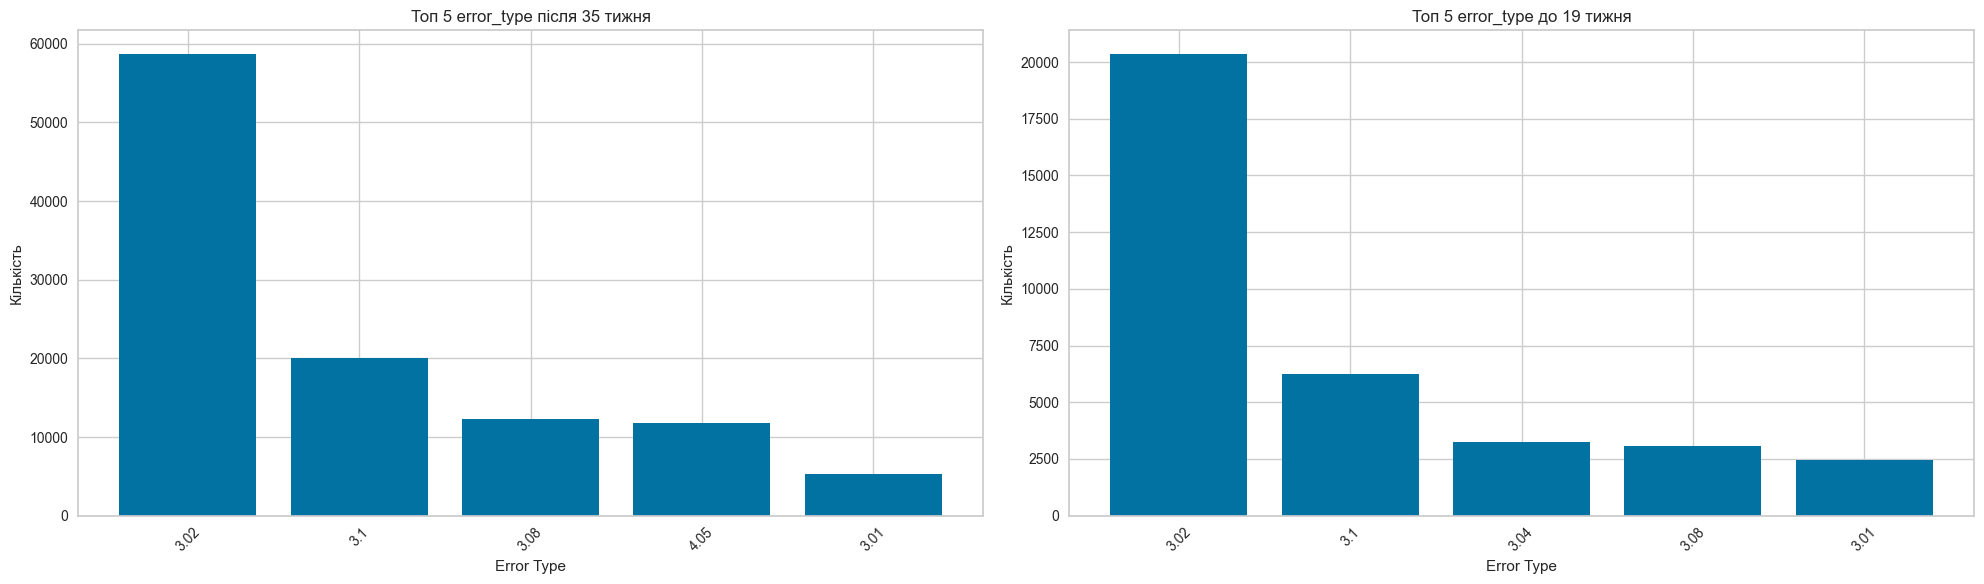

In [28]:
df_success = df[df['event_week'] < 19]
df_fail = df[df['event_week'] > 35]

df_fail['error_type'] = df_fail['error_type'].astype(str)
counts_fail = df_fail['error_type'].value_counts()[1:6]

df_success['error_type'] = df_success['error_type'].astype(str)
counts_success = df_success['error_type'].value_counts()[1:6]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].bar(counts_fail.index, counts_fail.values)
ax[0].set_title('Топ 5 error_type після 35 тижня')
ax[0].set_xlabel('Error Type')
ax[0].set_ylabel('Кількість')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(counts_success.index, counts_success.values)
ax[1].set_title('Топ 5 error_type до 19 тижня')
ax[1].set_xlabel('Error Type')
ax[1].set_ylabel('Кількість')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Бачимо, що з'явилася помилка 4.05. Розглянемо в який період вона з'явилася

Помилка 4.05: PSP проти шахрайства (Банк-еквайєр заблокував транзакцію через можливе шахрайство.)

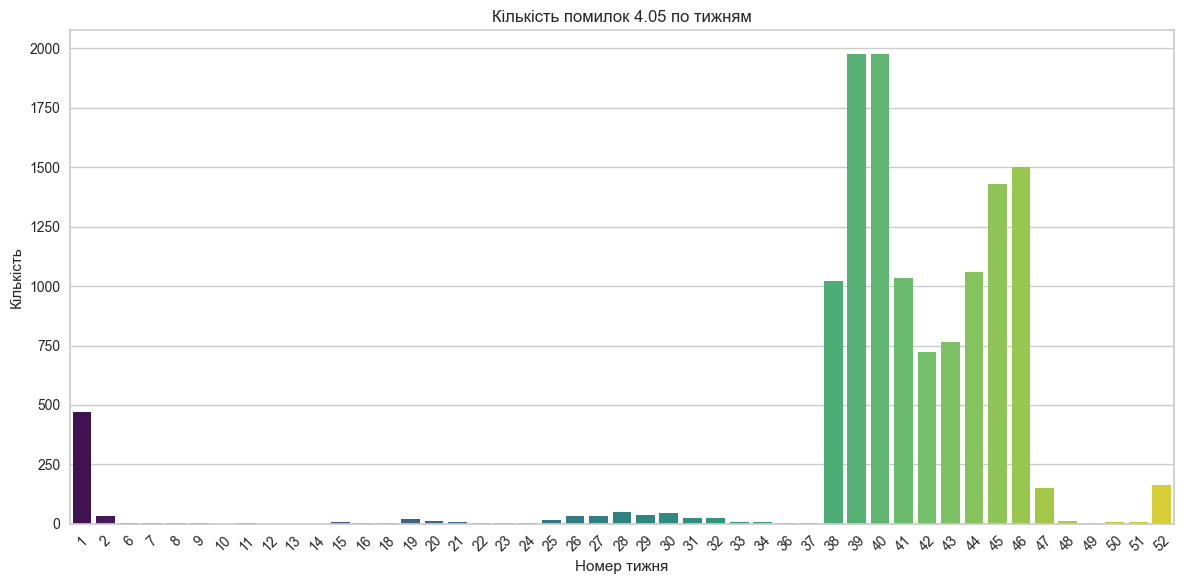

In [29]:
df_405 = df[df['error_type'] == 4.05]

plt.figure(figsize=(12, 6))  
sns.countplot(x='event_week', data=df_405, palette='viridis')

plt.title('Кількість помилок 4.05 по тижням')
plt.xlabel('Номер тижня')
plt.ylabel('Кількість')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Скоріш за все банки оновили anti-fraud систему, що і стало причиною таких різких змін у кількості відхилених транзакцій

### 2. Побудуй рейтинг найбільш ефективних та неефективних банків емітентів. Вкажи основні спільні характеристики транзакцій для останніх.

In [30]:
df.error_type.value_counts().head(10)

error_type
3.02    134627
3.10     43973
3.08     26380
3.04     15141
4.05     12706
3.01     12655
4.03     11897
2.08      8324
0.01      8072
5.01      5899
Name: count, dtype: int64

#### 3.02 (Недостатньо коштів) - На балансі картки користувача недостатньо коштів, це частина за яку відповідає користувач, а не банк, тому перед аналізом ефективності банків всі помилки типу 3.02 будуть видалені

In [31]:
df_banks = df[df.error_type != 3.02]

#### відсоток успішних транзакцій при яких банк вважатиметься ефективним (це значення можна змінити залежно від очікувань компанії)

In [32]:
effectiveness_threshold = 75

In [33]:
df_banks_success = df_banks[df_banks.transaction_status == 'success'].groupby('bank_name').agg({'transaction_status': 'count'})\
    .rename(columns={'transaction_status': 'amount_successed'}).reset_index()

In [34]:
df_banks_fail = df_banks[df_banks.transaction_status == 'fail'].groupby('bank_name').agg({'transaction_status': 'count'})\
    .rename(columns={'transaction_status': 'amount_failed'}).reset_index()

In [35]:
df_banks_rating = pd.merge(df_banks_fail, df_banks_success, how='outer')

In [36]:
df_banks_rating.head()

,bank_name,amount_failed,amount_successed
0,"""""""MOBIASBANCA - OTP GROUP"""" S.A.""",NaN,4.0
1,"""""""YELO BANK"""" OPEN JOINT-STOCK COMPANY""",NaN,1.0
2,"""ARMENIAN CARD"" CJSC",2.0,18.0
3,"""BANCO BILBAO VIZCAYA ARGENTARIA COLOMBIA S.A....",28.0,76.0
4,"""INTESA SANPAOLO BANK ALBANIA"" SHA.",3.0,1.0


In [37]:
df_banks_rating.isnull().sum()

bank_name              0
amount_failed        677
amount_successed    1270
dtype: int64

#### Пропуски свідчать про відсутність позитивних/відхилених транзакцій, тому замінимо Nan на 0

In [38]:
df_banks_rating.fillna(0, inplace=True)

In [39]:
df_banks_rating['success_rate'] = round(df_banks_rating.amount_successed * 100 / (df_banks_rating.amount_successed + df_banks_rating.amount_failed), 2)

In [40]:
df_banks_rating = df_banks_rating.sort_values(by=['success_rate', 'amount_successed'], ascending=[False, False])

In [41]:
df_banks_rating

,bank_name,amount_failed,amount_successed,success_rate
149,ALAHLI BANK OF KUWAIT (K.S.C.),0.0,72.0,100.0
2841,"MUFG BANK, LTD.",0.0,64.0,100.0
2790,MIDLAND STATES BANK,0.0,60.0,100.0
1351,CONVERSE BANK CORPORATION,0.0,55.0,100.0
4021,THE MAURITIUS COMMERCIAL BANK (SEYCHELLES) LIM...,0.0,54.0,100.0
...,...,...,...,...
4486,"Wilmington Savings Fund Society, FSB",1.0,0.0,0.0
4492,YAMPA VALLEY BANK,2.0,0.0,0.0
4494,YANDEX MONEY NBCO LLC,1.0,0.0,0.0
4496,YAPI VE KREDI BANKASI SA,1.0,0.0,0.0


#### Залишимо лише ті банки у яких кількість позитивних транзакцій < 75% (границя яку ми встановили раніше)

In [42]:
inefficient_banks_array = df_banks_rating[df_banks_rating.success_rate < effectiveness_threshold].bank_name

In [43]:
df_inefficient_banks = df_banks[df_banks.bank_name.isin(inefficient_banks_array)]

In [44]:
df_inefficient_banks.head()

,order_id,event_time,user_id,price,payment_number,transaction_status,card_brand,card_type,bank_name,error_type,currency,card_country,price_in_cad,day_of_week,event_week,region
0,c500aa10-30f8-4927-96c5-4e97b6afac83,2022-07-08 18:32:39,c1ed5188-caac-4d56-bad8-bc8ee0b09960,21.0,reccurent,fail,VISA,PREPAID,ADVANCED BANK OF ASIA LIMITED,3.08,USD,KHM,27.26,Friday,27,Other
2,4d75ca57-8883-49a9-b150-1ab7a47d12f8,2022-06-09 11:18:32,1005d4fb-1b7d-4715-835f-4d2a9bfe7cbb,36.0,initial,success,VISA,CREDIT,ICICI BANK LTD,NaN,USD,IND,45.14,Thursday,23,Other
4,3b19657f-1a34-4233-b25c-5d3b7fb32782,2022-06-17 15:16:47,bd2e4137-5526-4d9b-9dde-7482087fc321,9.0,reccurent,success,MASTERCARD,CREDIT,"CAPITAL ONE BANK (USA), NATIONAL ASSOCIATION",NaN,USD,USA,11.65,Friday,24,USA
5,d4d91e61-070c-47f5-b147-51aad5581537,2022-07-08 01:59:47,a18b15d1-ecfb-4607-a0d8-33b5619577f7,36.0,reccurent,success,MASTERCARD,DEBIT,"BANCO NACIONAL DE MEXICO, S.A.",NaN,USD,MEX,46.73,Friday,27,Other
9,b0db9d57-50dc-4757-a23c-dda2f9794d0d,2022-06-25 22:38:47,13bdf710-354a-4a29-9a9b-97cbcbd9527d,36.0,reccurent,success,VISA,CREDIT,IDFC FIRST BANK LIMITED,NaN,USD,IND,46.65,Saturday,25,Other


#### Проаналізуємо відхилені транзакцій в банках, щоб знайти можливі патерни

In [45]:
df_inefficient_banks = df_inefficient_banks[df_inefficient_banks.transaction_status == 'fail']

In [46]:
df_inefficient_banks.error_type.value_counts().head(10)

error_type
3.10    39253
3.08    23420
3.04    13249
4.05    11869
4.03    10669
3.01     9024
2.08     7513
0.01     7353
5.01     5182
4.09     4593
Name: count, dtype: int64

#### Аналіз найпопулярніших помилок

1) З помилок 3.10 і 4.05 бачимо, що банки серйозно ставляться до антифрод систем, але так само може бути проблема з тим, що ці системи занадто чутливі і часто можуть помилково спрацьовувати (я б знизив precision в цих системах)
2) З помилки 3.08 бачимо недостатню прозорість у комунікації між банками та їх клієнтами, тому клієнти швидше за все не можуть зрозуміти проблему
3) З помилки 3.04, можливо банку слід глибше аналізувати поведінку своїх клієнтів, щоб знизити ймовірність помилкового блокування легітимних операцій.
4) Помилки 0.01 і 2.08 говорять про технічні проблеми або помилки з боку користувачів при введенні даних картки, швидше за все потрібно покращити користувальницький інтерфейс і валідацію даних на стадії введення, щоб знизити частину відмов у транзакціях
5) Помилка 4.03 може вказувати на сувору безпекову політику банку, а також високий ризик шахрайства серед його клієнтів.

#### Також проаналізуємо інші ймовірні залежності

In [47]:
df_inefficient_banks_region = df_inefficient_banks.region.value_counts().reset_index()

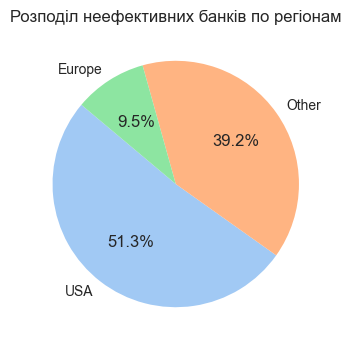

In [48]:
plt.figure(figsize=(6, 4))
plt.pie(df_inefficient_banks_region['count'], colors=sns.color_palette("pastel"), labels=df_inefficient_banks_region.region, autopct='%1.1f%%', startangle=140)
plt.title('Розподіл неефективних банків по регіонам')
plt.show()

#### Бачимо, що більшість неефективних банків перебувають у USA і всього лише 10% у Європі

In [49]:
card1_df = df_inefficient_banks.card_brand.value_counts().head().reset_index().rename(columns={'count': 'amount'})

In [50]:
card2_df = df_banks.card_brand.value_counts().head().reset_index().rename(columns={'count': 'total'})

In [51]:
df_inefficient_banks_card = pd.merge(card1_df, card2_df)

In [52]:
df_inefficient_banks_card

,card_brand,amount,total
0,VISA,102060,279420
1,MASTERCARD,45118,139190
2,AMEX,3996,6693
3,DISCOVER,998,1486
4,RUPAY,821,821


#### Visa & MasterCard мають найбільшу кількість відхилених транзакцій, але це неправильно робити висновки по кількості, проаналізуємо відсоток відхилених транзакцій

In [53]:
df_inefficient_banks_card['part_total'] = round(df_inefficient_banks_card.amount * 100 / df_inefficient_banks_card.total, 2)

In [54]:
df_inefficient_banks_card.sort_values(by='part_total', ascending=False)

,card_brand,amount,total,part_total
4,RUPAY,821,821,100.00
3,DISCOVER,998,1486,67.16
2,AMEX,3996,6693,59.70
0,VISA,102060,279420,36.53
1,MASTERCARD,45118,139190,32.41


#### Видно, що непопулярні бренди карт мають найбільшу частину провальних транзакцій більше 50%

### 3. Від чого залежить структура помилок транзакцій, чи є якісь чіткі патерни?

#### В даному блоці використаємо Machine Learning, а саме Clustering, щоб знайти глибокі взаємозв'язки в даних

In [55]:
df[df.transaction_status == 'fail'].head()

,order_id,event_time,user_id,price,payment_number,transaction_status,card_brand,card_type,bank_name,error_type,currency,card_country,price_in_cad,day_of_week,event_week,region
0,c500aa10-30f8-4927-96c5-4e97b6afac83,2022-07-08 18:32:39,c1ed5188-caac-4d56-bad8-bc8ee0b09960,21.0,reccurent,fail,VISA,PREPAID,ADVANCED BANK OF ASIA LIMITED,3.08,USD,KHM,27.26,Friday,27,Other
1,624d6f30-c1bc-4778-a23e-6a227bac73ac,2022-06-09 22:18:36,c9ff65b8-75e6-467f-8715-21edb5fd06af,36.0,reccurent,fail,VISA,PREPAID,UNITED BANK FOR AFRICA GHANA LIMITED,3.02,USD,GHA,45.14,Thursday,23,Other
3,3fd11eed-4236-46aa-8f21-3c1e1a17a1bc,2022-06-29 13:50:47,866c4b2b-0285-43aa-98bd-d60bc3a78d7c,36.0,reccurent,fail,VISA,DEBIT,THE TORONTO-DOMINION BANK,3.02,USD,CAN,46.24,Wednesday,26,Other
6,f5afea32-418c-4dab-8067-ed4e2795ca7f,2022-07-11 12:07:50,0c16973b-1b93-4a5d-9317-b2e82f996bae,36.0,reccurent,fail,VISA,DEBIT,MALAYAN BANKING BERHAD,3.02,USD,MYS,46.77,Monday,28,Other
7,37e9c9da-35e3-4ae3-8d8c-96acc5b2632f,2022-06-24 04:34:36,99aa42fc-ce29-4e8f-87d7-42596fad86e9,36.0,reccurent,fail,MASTERCARD,DEBIT,TURKIYE GARANTI BANKASI A.S.,3.04,USD,TUR,46.65,Friday,25,Other


#### Для початку підготовимо дані й замінимо категоріальні дані на числові

In [56]:
df_selected = df[df.transaction_status == 'fail'][['price',  'currency', 'day_of_week', 'card_type', 'card_brand', 'payment_number', 'region']].dropna()
df_fail_clusters = df[df.transaction_status == 'fail'][['price', 'currency', 'day_of_week', 'card_type', 'card_brand', 'payment_number', 'region']].dropna()

df_selected.head()

,price,currency,day_of_week,card_type,card_brand,payment_number,region
0,21.0,USD,Friday,PREPAID,VISA,reccurent,Other
1,36.0,USD,Thursday,PREPAID,VISA,reccurent,Other
3,36.0,USD,Wednesday,DEBIT,VISA,reccurent,Other
6,36.0,USD,Monday,DEBIT,VISA,reccurent,Other
7,36.0,USD,Friday,DEBIT,MASTERCARD,reccurent,Other


In [57]:
le_currency = LabelEncoder()
df_selected['currency'] = le_currency.fit_transform(df_selected['currency'])

le_day_of_week = LabelEncoder()
df_selected['day_of_week'] = le_day_of_week.fit_transform(df_selected['day_of_week'])

le_card_type = LabelEncoder()
df_selected['card_type'] = le_card_type.fit_transform(df_selected['card_type'])

le_card_brand = LabelEncoder()
df_selected['card_brand'] = le_card_brand.fit_transform(df_selected['card_brand'])

le_payment_number = LabelEncoder()
df_selected['payment_number'] = le_payment_number.fit_transform(df_selected['payment_number'])

le_payment_region = LabelEncoder()
df_selected['region'] = le_payment_number.fit_transform(df_selected['region'])

In [58]:
df_selected.head()

,price,currency,day_of_week,card_type,card_brand,payment_number,region
0,21.0,1,0,5,14,1,1
1,36.0,1,4,5,14,1,1
3,36.0,1,6,3,14,1,1
6,36.0,1,1,3,14,1,1
7,36.0,1,0,3,9,1,1


#### Для того щоб кластеризація була краще - нормалізуємо дані

In [59]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

#### Визначимо оптимальну кількість кластерів за допомогою метода локтя і візуалізуємо

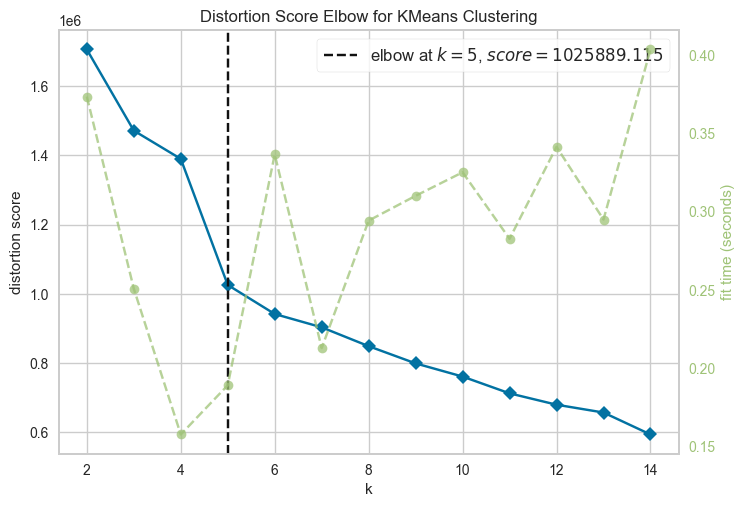

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (2, 15),
                              locate_elbow = True)
visualizer.fit(df_scaled)
visualizer.poof()

#### Оптимальна кількість кластерів - 5, тому використиаємо K-means++ за відсутності великої кількості викидів

In [61]:
kmeansmodel = KMeans(n_clusters=5, init='k-means++', random_state=512)

In [62]:
clusters = kmeansmodel.fit_predict(df_scaled)

In [63]:
df_fail_clusters['number_cluster'] = clusters

In [64]:
df_fail_clusters.head()

,price,currency,day_of_week,card_type,card_brand,payment_number,region,number_cluster
0,21.0,USD,Friday,PREPAID,VISA,reccurent,Other,1
1,36.0,USD,Thursday,PREPAID,VISA,reccurent,Other,1
3,36.0,USD,Wednesday,DEBIT,VISA,reccurent,Other,4
6,36.0,USD,Monday,DEBIT,VISA,reccurent,Other,4
7,36.0,USD,Friday,DEBIT,MASTERCARD,reccurent,Other,3


#### За допомогою циклу пройдемося по кожному кластеру й дістанемо основну інформацію

In [65]:
for i in sorted(df_fail_clusters['number_cluster'].unique()):
    print(f"Кластер {i}:")
    display(df_fail_clusters[df_fail_clusters['number_cluster'] == i].describe(include='all'))
    print("\n")

Кластер 0:


,price,currency,day_of_week,card_type,card_brand,payment_number,region,number_cluster
count,33318.000000,33318,33318,33318,33318,33318,33318,33318.0
unique,NaN,2,7,3,8,2,3,NaN
top,NaN,USD,Friday,CREDIT,MASTERCARD,reccurent,Other,NaN
freq,NaN,29347,13234,32969,28570,30660,18517,NaN
mean,31.312024,NaN,NaN,NaN,NaN,NaN,NaN,0.0
std,14.025032,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
25%,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
50%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0




Кластер 1:


,price,currency,day_of_week,card_type,card_brand,payment_number,region,number_cluster
count,75378.000000,75378,75378,75378,75378,75378,75378,75378.0
unique,NaN,2,7,4,1,2,2,NaN
top,NaN,USD,Friday,DEBIT,VISA,reccurent,USA,NaN
freq,NaN,75363,30526,41597,75378,75344,68692,NaN
mean,33.835549,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,14.822134,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0




Кластер 2:


,price,currency,day_of_week,card_type,card_brand,payment_number,region,number_cluster
count,72378.000000,72378,72378,72378,72378,72378,72378,72378.0
unique,NaN,2,7,6,13,1,3,NaN
top,NaN,USD,Sunday,DEBIT,VISA,initial,USA,NaN
freq,NaN,68795,10712,43795,49703,72378,40737,NaN
mean,7.030092,NaN,NaN,NaN,NaN,NaN,NaN,2.0
std,5.780455,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.0
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.0
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.0
75%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.0




Кластер 3:


,price,currency,day_of_week,card_type,card_brand,payment_number,region,number_cluster
count,55147.000000,55147,55147,55147,55147,55147,55147,55147.0
unique,NaN,2,7,2,5,2,3,NaN
top,NaN,USD,Friday,DEBIT,MASTERCARD,reccurent,Other,NaN
freq,NaN,48516,22712,54976,54932,54974,28683,NaN
mean,32.751156,NaN,NaN,NaN,NaN,NaN,NaN,3.0
std,14.083299,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.0
25%,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.0
50%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.0
75%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.0




Кластер 4:


,price,currency,day_of_week,card_type,card_brand,payment_number,region,number_cluster
count,75426.000000,75426,75426,75426,75426,75426,75426,75426.0
unique,NaN,2,7,5,1,2,3,NaN
top,NaN,USD,Friday,DEBIT,VISA,reccurent,Other,NaN
freq,NaN,63576,30777,59859,75426,74881,59545,NaN
mean,32.321507,NaN,NaN,NaN,NaN,NaN,NaN,4.0
std,13.176944,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
25%,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
50%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.0
75%,36.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.0


### Аналіз кластерів: Основні висновки

**День тижня**: Визначені дні, як п'ятниця і неділя, частіше всього зустрічаються в деяких кластерах, що може вказувати на підвищення активності та помилок у ці дні.

**Тип карти**: Більшість помилок транзакцій приходить на дебетові карти. Це може бути пов'язано з недостатнім балансом (помилка 3.02, яка з'являється частіше за все) або обмеженнями на операції (помилки, які були розглянуті в минулому блоці з аналізом неефективності банків).

**Карти брендів**: Visa і MasterCard найчастіше зустрічаються у всіх кластерах, що може свідчити про їх популярність і, відповідно, більшу кількість транзакцій з помилками.

**Регіон**: деякі кластери демонструють географічну специфіку (наприклад, USA та Other), що може показувати різні шаблони використання карт і транзакцій у різних регіонах.

**Сума транзакцій**: Основні суми, з якими виникають проблеми, це рекурентні платежі по 36 доларів і перший платіж по 5 доларів.


### 4. Чи можна стверджувати, що серед транзакцій наявні такі, що здійснені в рамках підписки? Якщо так, чи можна виявити її основні параметри (сума списання, періодичність, наявність тріального періоду тощо).

In [66]:
df = df.sort_values(by=['user_id', 'event_time'])

In [67]:
df_transaction_success = df[df.transaction_status == 'success']

In [68]:
df_transaction_success.price.unique()

array([ 5., 64., 90., 27.,  6.,  9., 36., 29., 38., 21.,  4., 43., 12.,
        7., 10., 23., 73., 20., 19., 14., 33., 24., 54., 28., 16., 55.,
       32., 22., 41.,  8., 26., 53., 18., 17., 48., 35., 46., 42.])

##### не видно 0 тому припускаємо, що триальний період це сама дешева транзакція

In [69]:
df_transaction_success.price.value_counts().head(10)

price
36.0    70797
21.0    51117
5.0     48628
9.0     24457
12.0    10024
24.0     8213
38.0     6224
6.0      5417
43.0     4334
27.0     4250
Name: count, dtype: int64

In [70]:
df_transaction_success.groupby(['price', 'payment_number']).agg({'user_id': 'count'}).reset_index() \
    .rename(columns={'user_id': 'amount'}).sort_values(by='amount', ascending=False).head(10)

,price,payment_number,amount
37,36.0,reccurent,70788
21,21.0,reccurent,50982
2,5.0,initial,46780
8,9.0,reccurent,24457
26,24.0,reccurent,8213
38,38.0,reccurent,6224
11,12.0,reccurent,5030
10,12.0,initial,4994
4,6.0,initial,4899
41,43.0,reccurent,4334


##### бачимо, що сама популярна початкова оплата це 5, робимо висновок, що скоріше всього це і є пробний період тільки по знижці, так само в топ 3 рекурентних оплат входить 36, 21, 9, але щоб краще дізнатися причину різниці цін розглянемо оплати по тижневим проміжкам

In [71]:
df_transaction_success['time_diff'] = df_transaction_success.groupby('user_id')['event_time'].diff().dt.days

In [72]:
df_transaction_success[df_transaction_success.payment_number == 'reccurent'] \
    .groupby(['price', 'payment_number']).agg({'time_diff': 'median', 'user_id': 'count'}).reset_index() \
    .rename(columns={'user_id': 'amount'}).sort_values(by='amount', ascending=False).head(10)

,price,payment_number,time_diff,amount
25,36.0,reccurent,14.0,70788
14,21.0,reccurent,7.0,50982
5,9.0,reccurent,6.0,24457
17,24.0,reccurent,7.0,8213
26,38.0,reccurent,30.0,6224
7,12.0,reccurent,7.0,5030
29,43.0,reccurent,14.0,4334
21,29.0,reccurent,0.0,3293
13,20.0,reccurent,22.0,2298
33,54.0,reccurent,14.0,2046


##### ціна 21 це підписка на 7 днів, а ціна яка йде за 14 днів це 36, я бачу що ціна трохи менше щоб отримати вигоду, але звідси складно зрозуміти інші ціни, можна припустити що така різновидність цін з'явилася через різні акції

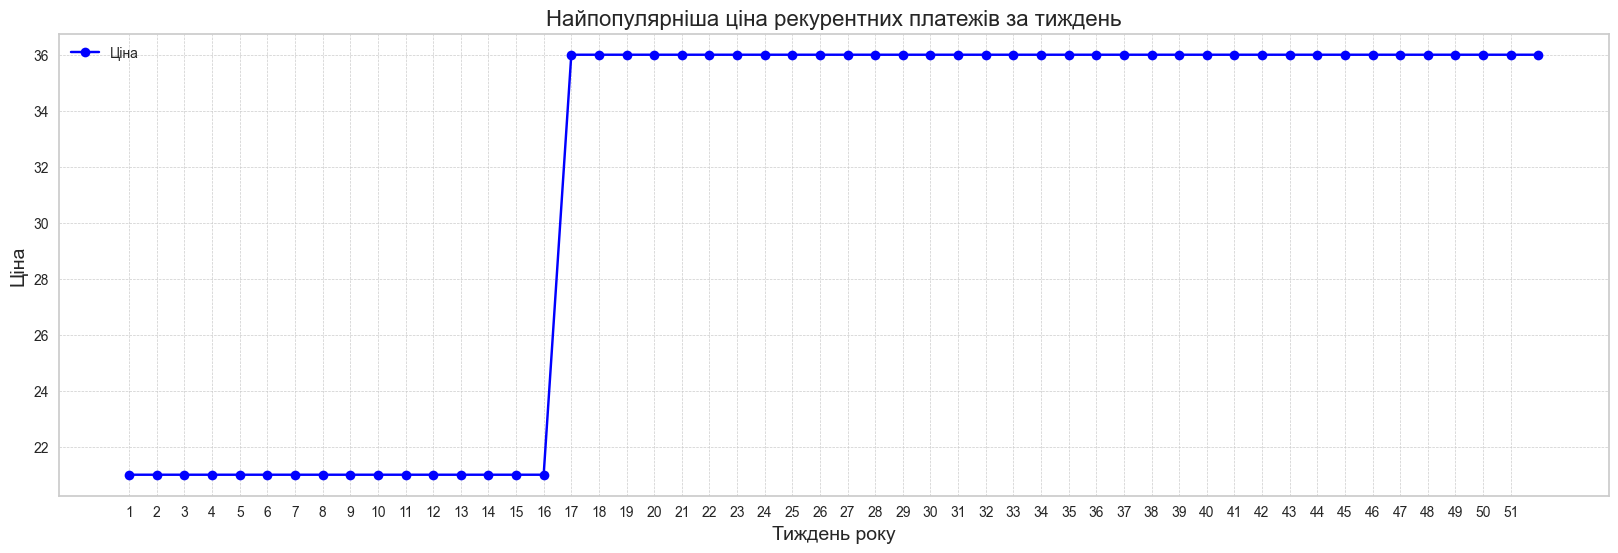

In [73]:
price_count_per_week = df[df.payment_number == 'reccurent'].groupby(['event_week', 'price']).size().reset_index(name='count')

popular_price_per_week = price_count_per_week.loc[price_count_per_week.groupby('event_week')['count'].idxmax()]

plt.figure(figsize=(20, 6))

plt.plot(popular_price_per_week['event_week'], popular_price_per_week['price'], marker='o', linestyle='-', color='blue')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel('Тиждень року', fontsize=14)
plt.ylabel('Ціна', fontsize=14)

plt.title('Найпопулярніша ціна рекурентних платежів за тиждень', fontsize=16)

plt.legend(['Ціна'], loc='best')
plt.xticks(np.arange(min(popular_price_per_week['event_week']), max(popular_price_per_week['event_week']), 1))

plt.show()

##### як додатковий факт, видно, що юзери купували спочатку 7 денну підписку за 21, але після 16-ої неділі більша частина юзерів перейшла на 14 денну підписку за 36

### Основні висновки

##### Транзакції які відбулись під час підписки дійсно є, це відразу видно по рекурентним платежам, провівши аналіз, ми бачимо, що пробний період реалізовано не безкоштовно, як це прийнято, а зі знижкою на 1 тиждень користування, пробний період триває 7 днів після чого велика частина користувачів купує або 7-денну підписку, або 14-денну підписку. Так само видно, що підписка за 14 днів набрала найбільшої популярності після 16 тижня 2022 року

### 5. Побудуй графік загальної поденної виручки в CAD (канадський долар).

#### На самому початку за допомогою API для кожної дати, залежно від валюти(USD або Euro) було розраховано відносний price у CAD

In [74]:
daily_revenue = df.groupby(df['event_time'].dt.date)['price_in_cad'].sum().reset_index()

In [75]:
daily_revenue.event_time = pd.to_datetime(daily_revenue.event_time)

In [76]:
daily_revenue['day_of_week'] = daily_revenue['event_time'].dt.day_name()

In [77]:
daily_revenue.head()

,event_time,price_in_cad,day_of_week
0,2022-01-01,21428.78,Saturday
1,2022-01-02,32488.27,Sunday
2,2022-01-03,17843.84,Monday
3,2022-01-04,22704.29,Tuesday
4,2022-01-05,24596.07,Wednesday


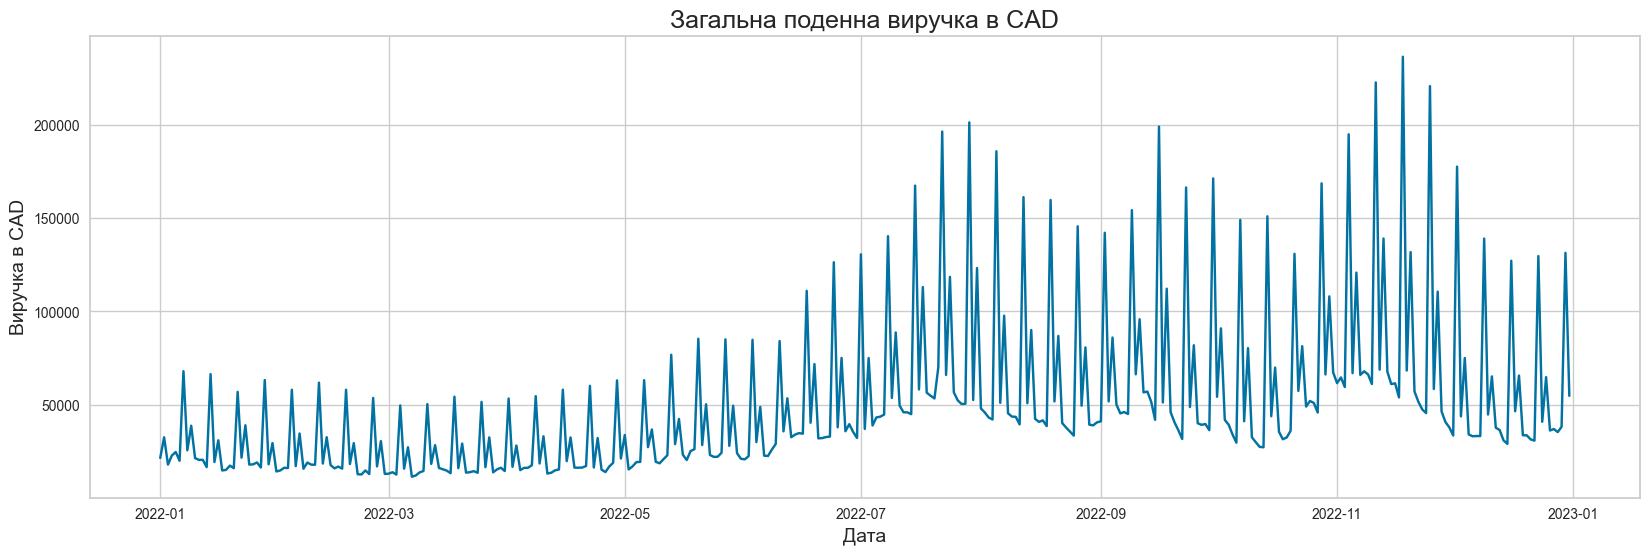

In [78]:
plt.figure(figsize=(20, 6))
plt.plot(daily_revenue.event_time, daily_revenue.price_in_cad)
plt.title('Загальна поденна виручка в CAD', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Виручка в CAD', fontsize=14)
plt.show()

#### Видно регулярні сплески по виручці, потрібно це дослідити, подивимося на виручку в розрізі по днях

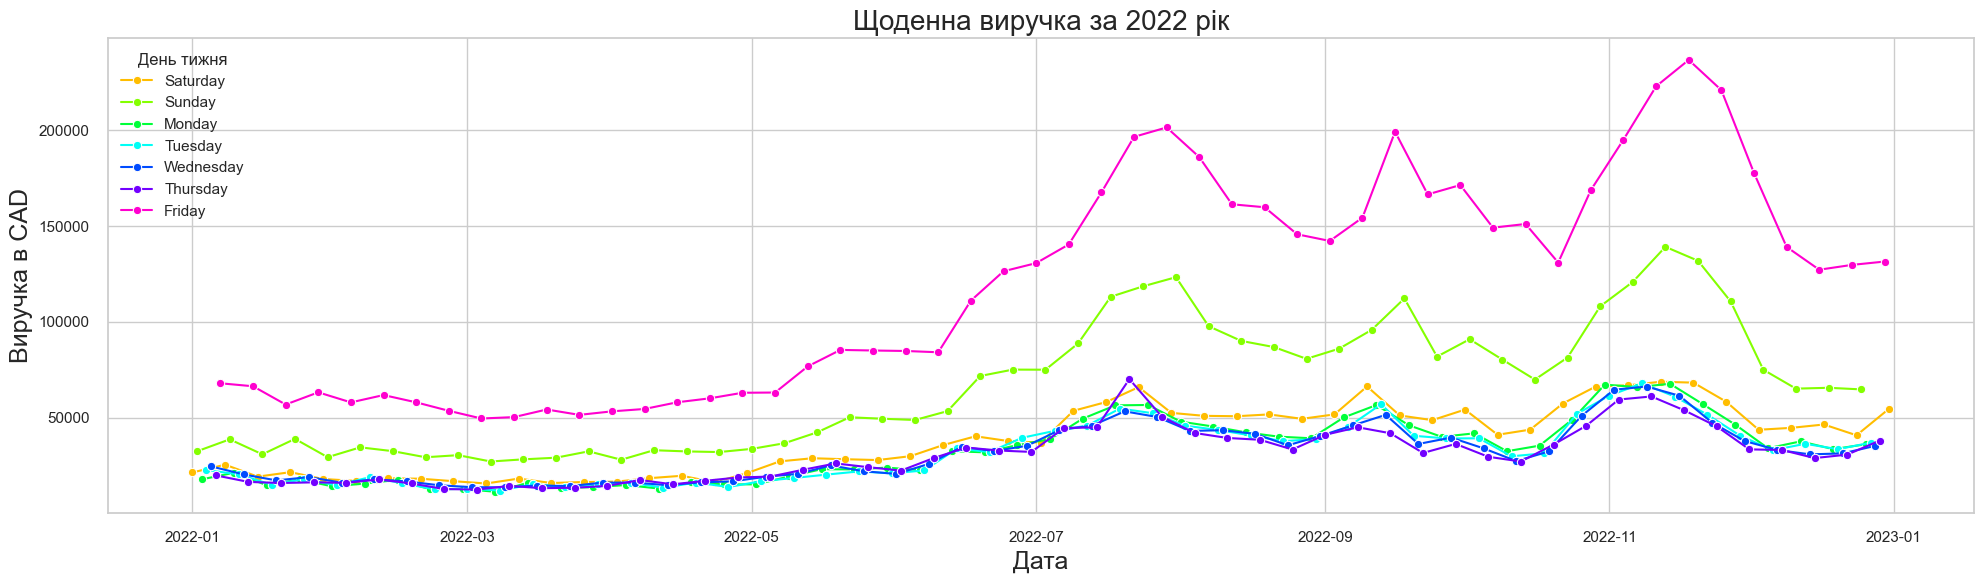

In [79]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))

palette = sns.color_palette("hsv", len(daily_revenue['day_of_week'].unique()))
sns.lineplot(x='event_time', y='price_in_cad', hue='day_of_week', palette=palette, data=daily_revenue, marker="o")


plt.title('Щоденна виручка за 2022 рік', fontsize=20)
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Виручка в CAD', fontsize=18)

plt.legend(title='День тижня', loc='upper left')

plt.tight_layout()
plt.show()

#### П'ятниця й Неділя найприбутковіші дні порівняно з іншими днями які по виручці розподілені рівномірно, тому ми й бачимо такі регулярні сплески

### 6. Аналіз Retention по транзакціям

#### Додатково проаналізуємо після якої кількості транзакцій люди перестають подовжувати підписку

In [80]:
df = df.sort_values(by=['user_id', 'event_time'])

transactions_per_user = df[df.transaction_status == 'success'].groupby('user_id')['order_id'].count()

In [81]:
transactions_per_user.describe().T

count    70074.000000
mean         3.582898
std          5.954294
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        106.000000
Name: order_id, dtype: float64

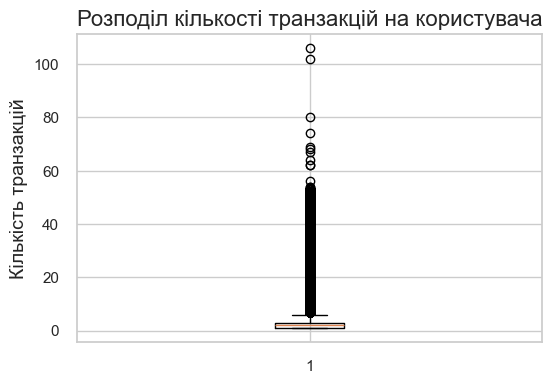

In [82]:
plt.figure(figsize=(6, 4))  
plt.boxplot(transactions_per_user)

plt.title('Розподіл кількості транзакцій на користувача', fontsize=16)
plt.ylabel('Кількість транзакцій', fontsize=14)

plt.grid(True)  
plt.show()


#### Наявно дуже багато викидів, тому якщо 3 квартиль це 3 транзакції, то залишимо лише максимум 10 транзакцій на одного користувача

In [83]:
transactions_per_user = transactions_per_user[transactions_per_user < 10]

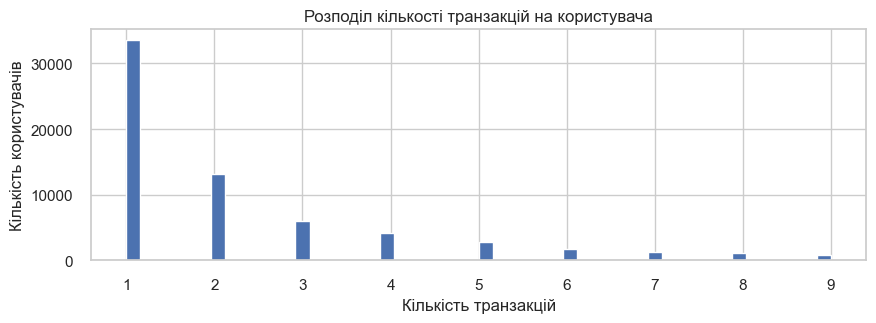

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))

transactions_per_user.hist(bins=50)
plt.title('Розподіл кількості транзакцій на користувача')
plt.xlabel('Кількість транзакцій')
plt.ylabel('Кількість користувачів')
plt.show()

#### Більша частина користувачів, перестає подовжувати підписку після 4 успішних транзакцій, на це варто звернути увагу й знайти рішення, можливо є сенс створити персональні пропозиції. Як варіант, можна також нагороджувати користувачів за підписку балами, які потім можна обміняти на знижку

### 7. Аналіз транзакцій залежно від часу

In [85]:
df['hour_of_day'] = df['event_time'].dt.hour

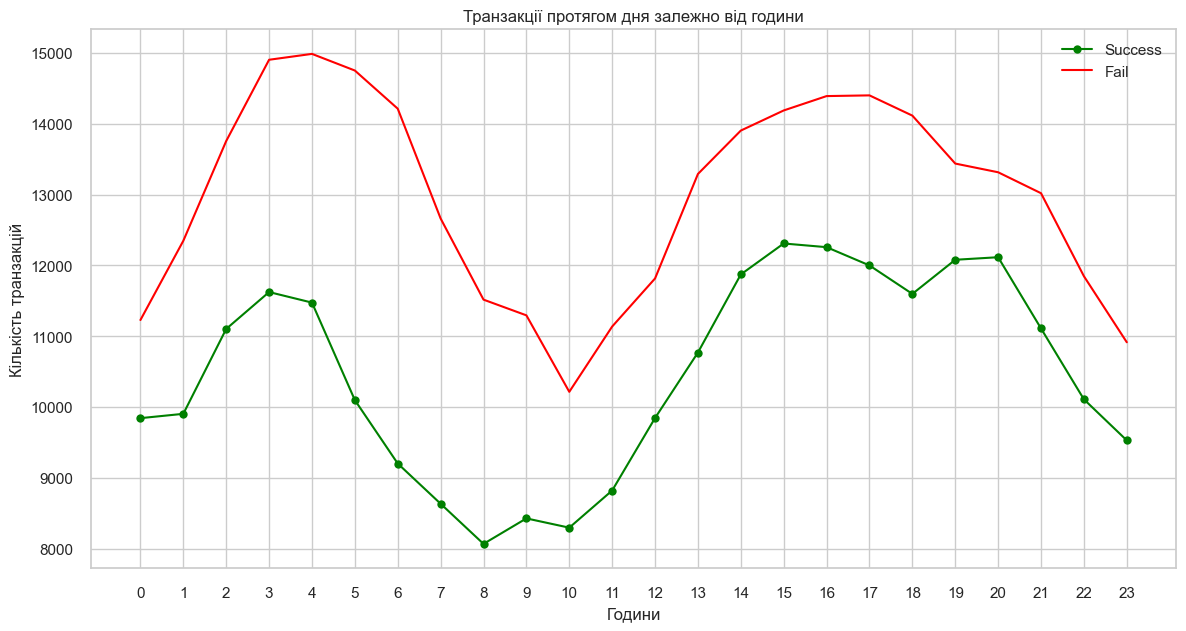

In [86]:
success_transactions = df[df['transaction_status'] == 'success'].groupby('hour_of_day').size()
fail_transactions = df[df['transaction_status'] == 'fail'].groupby('hour_of_day').size()

plt.figure(figsize=(14, 7))
plt.plot(success_transactions, label='Success', color='green', marker='o')
plt.plot(fail_transactions, label='Fail', color='red', marker='x')
plt.title('Транзакції протягом дня залежно від години')
plt.xlabel('Години')
plt.ylabel('Кількість транзакцій')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()

#### Більше за все транзакцій вночі та ввечері (на це ймовірно впливає часовий пояс), але ввечері різниця між успішними та відхиленими транзакціями набагато менша порівняно з ніччю. 

#### Спробуємо за допомогою методу хі-квадрат підтвердити гіпотезу, що час впливає на кількість успішних транзакцій

In [87]:
from scipy.stats import chi2_contingency

ab_info = pd.DataFrame({
    'Success': success_transactions,
    'Fail': fail_transactions
})

In [88]:
ab_info.head()

,Success,Fail
hour_of_day,,
0,9842,11228
1,9903,12347
2,11102,13756
3,11623,14904
4,11474,14987


In [89]:
chi2, p, dof, expected = chi2_contingency(ab_info)

print(f"Chi-squared Test Statistic: {chi2}")
print(f"p-value: {p}")
print('')
if p < 0.05:
     print("Є статистично значуща залежність між часом доби та успішністю транзакції")
else:
     print("Немає статистично значущої залежності між часом доби і успішністю транзакції")


Chi-squared Test Statistic: 1091.1802558972986
p-value: 5.287058678500542e-216

Є статистично значуща залежність між часом доби та успішністю транзакції


#### Гіпотеза підтверджена й залежність між часом та успішністю транзакції дійсно існує

# Результати

## 1. Потижнева прохідність платежів по локаціях

### США та інші країни:
- Кількість успішних транзакцій не сильно відрізняється від кількості провалених транзакцій.

### Європа:
- На початку спостерігалася значно більша кількість успішних транзакцій.
- З часом кількість провалених транзакцій аномально зросла через появу нової помилки 4.05, яка, ймовірно, пов'язана з оновленням анти-фрод систем банками.

## 2. Рейтинг банків емітентів

### Ефективні банки:
Топ-5 банків зі 100% успішними транзакціями:
1. ALAHLI BANK OF KUWAIT (K.S.C.)
2. MUFG BANK, LTD.
3. MIDLAND STATES BANK
4. CONVERSE BANK CORPORATION
5. THE MAURITIUS COMMERCIAL BANK (SEYCHELLES) LIMITED

### Неефективні банки:
- Для аналізу взято банки з менш ніж 75% успішних транзакцій.
- Серед них було виявлено велику кількість помилок 3.02 (недостатньо коштів). Однак, ця проблема більше стосується клієнтів, ніж банків.
- Більшість помилок вказують на жорсткі анти-фрод системи або недостатню прозорість між банком та клієнтом.
- Помилки 0.01 і 2.08 свідчать про технічні проблеми або помилки з боку користувачів при введенні даних картки. Це вказує на необхідність покращення користувальницького інтерфейсу та валідації даних на стадії введення для зниження частини відмов у транзакціях.


## 3. Структура помилок транзакцій
Для виявлення патернів помилок транзакцій застосовано машинне навчання без вчителя - кластеризацію. Виділені основні тенденції:

- **День тижня:** Помилки частіше зустрічаються в п'ятницю та неділю, що вказує на збільшення активності користувачів у ці дні.
- **Тип карти:** Дебетові карти мають вищу кількість помилок, ймовірно, через недостатній баланс або обмеження на операції.
- **Карти брендів:** Visa і MasterCard домінують у помилках, що свідчить про їх широке використання.
- **Регіон:** Існують географічні особливості у помилках, наприклад, кластери, характерні для США та інших країн.
- **Сума транзакцій:** Проблемні суми включають рекурентні платежі на суму 36 та перший платіж 5.

## 4. Аналіз підписок
Для кращого розуміння цін, було проаналізовано декілька продуктів OBRIO таких як Nebula й Online chat з тарологами тощо. Було виявлено, що у Nebula користувачі платять фіксовану суму(підписку), в онлайн чаті ж, людина може купити багато токенів, що може справокувати сильний розкид у цінах по транзакціям. Аналіз же показав, що користувачі загалом, платили фіксовану суму, тому ймовірно ми маємо справу з історичними даними Nebula. 

- **Висновок:** Пробний період надається не безкоштовно, а зі знижкою та триває 7 днів (коштує 5). Найпопулярнішими є 7-денні (за 21) та 14-денні (за 36) підписки, особливо після 16-го тижня 2022 року.


## 5. Аналіз загальної поденної виручки в CAD
За допомогою API було отримано курс USD та EUR до CAD, враховуючи зміну курсу в залежності від дати. Графік виручки показав періодичні всплески, особливо помітні в п'ятницю та неділю, що вказує на збільшення кількості транзакцій у ці дні.

### Додатковий аналіз поведінки користувачів:

#### Короткострокове використання

Аналіз показав, що більшість користувачів здійснює менше ніж чотири транзакції через додаток, що вказує на потребу в стимулюванні довгострокового використання. 

**Пропозиції для збільшення залученості:**

- Розробка персональних пропозицій.
- Введення системи нагород за підписку, що може включати бали для обміну на знижки або унікальні бонуси.

#### Оптимальний час для транзакцій

Було виявлено, що **найкращий час для здійснення транзакцій** - вечірні години з 15:00 до 20:00. Цей період характеризується найвищою кількістю успішних транзакцій порівняно з невдалими. Це може бути використано для планування маркетингових акцій та спеціальних пропозицій.

## Висновок

Зібрані дані та аналіз поведінки користувачів надають цінну інформацію для розробки стратегій залучення та утримання клієнтів. Ініціативи, спрямовані на збільшення кількості транзакцій та підвищення задоволеності користувачів, можуть сприяти зростанню загальної виручки та покращенню репутації додатку на ринку.